# Modeling Challenge - Nationwide Insurance

# Part 1:

To start with, let's load the data and check for missing value.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix
from sklearn import metrics

from sklearn import preprocessing, svm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as off
import plotly.graph_objs as go

off.init_notebook_mode(connected=True)

C:\Users\baoji\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data=pd.read_csv(r'C:\Users\baoji\Desktop\salaries.csv', index_col=0)
print(data.shape)
data.head()

(397, 6)


,rank,discipline,yrs.since.phd,yrs.service,sex,salary
1,Prof,B,19,18,Male,139750
2,Prof,B,20,16,Male,173200
3,AsstProf,B,4,3,Male,79750
4,Prof,B,45,39,Male,115000
5,Prof,B,40,41,Male,141500


In [3]:
for i in ['rank','discipline','sex']:
    print(i+" contains values:")
    print(data[i].unique())

rank contains values:
['Prof' 'AsstProf' 'AssocProf']
discipline contains values:
['B' 'A']
sex contains values:
['Male' 'Female']


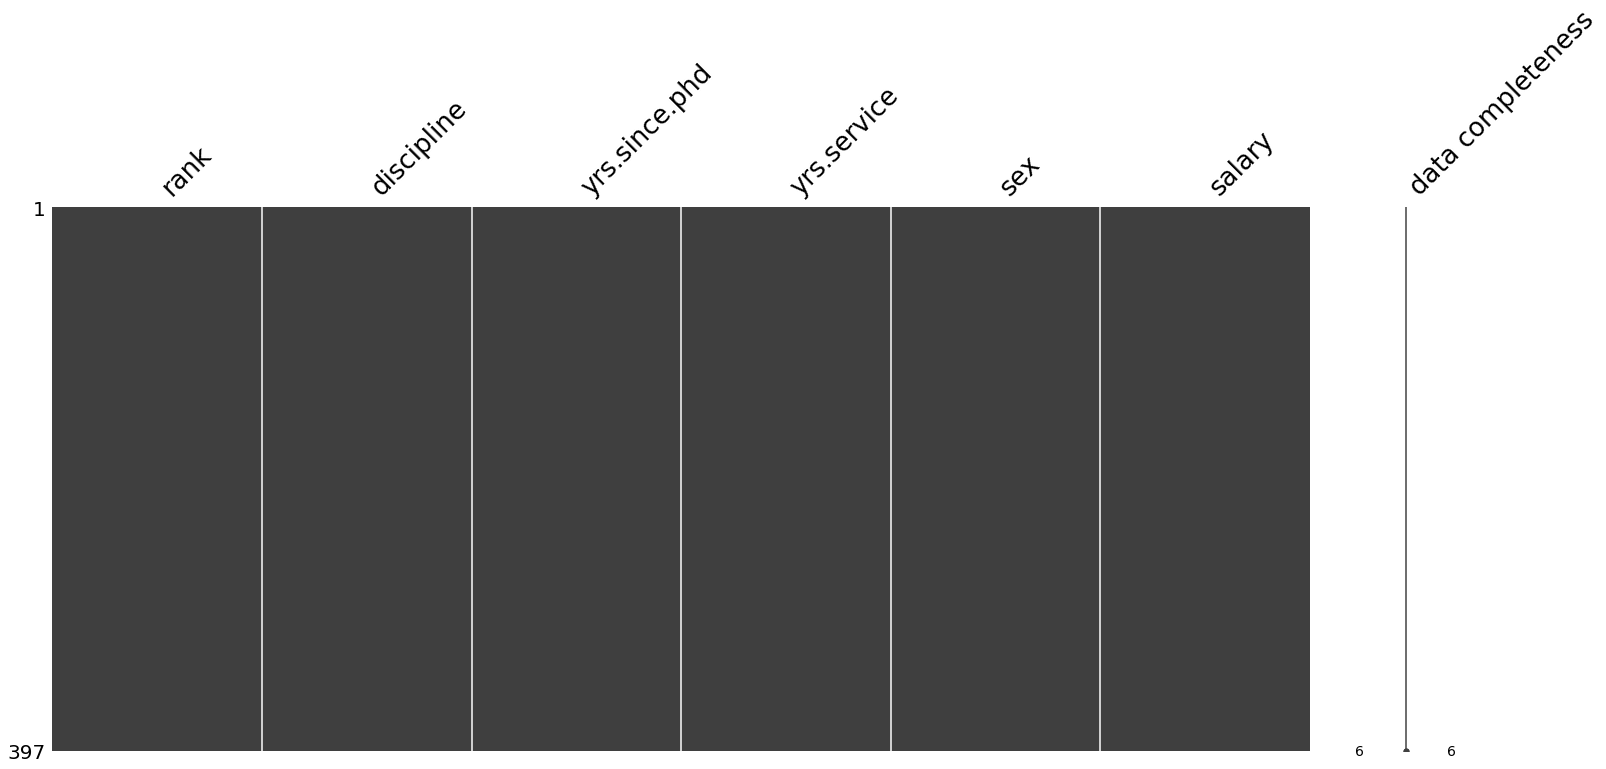

In [4]:
import missingno as msno
%matplotlib inline
msno.matrix(data,labels=True,fontsize=26)

No missing value. Now let's start answering the questions.

(1) What percentage of records are Assistant Professors with less than 5 years of experience?

Answer: 15.87%

In [5]:
len(data[(data['rank']=='AsstProf') & (data['yrs.service']<5)])/len(data['rank'])

0.15869017632241814

(2) Is there a statistically significant difference between female and male salaries?

Yes, there is a significant difference between female and male saleries. This t-test has the null hypothesis that both samples have the same mean values. The P-value is 0.005 which is small enough to reject the null hypothesis. 

In [6]:
female_salary = data[data['sex'] == 'Female']['salary']
male_salary = data[data['sex'] == 'Male']['salary']
stats.ttest_ind(female_salary, male_salary)   

Ttest_indResult(statistic=-2.781674064262432, pvalue=0.0056671065193386813)

(3) What is the distribution of salary by rank and discipline?

All of the distributions are right skewed. However, it is clear that the salaries of assistant professor are in the lower range. And discipline B has a higher salary than discipline A in general.

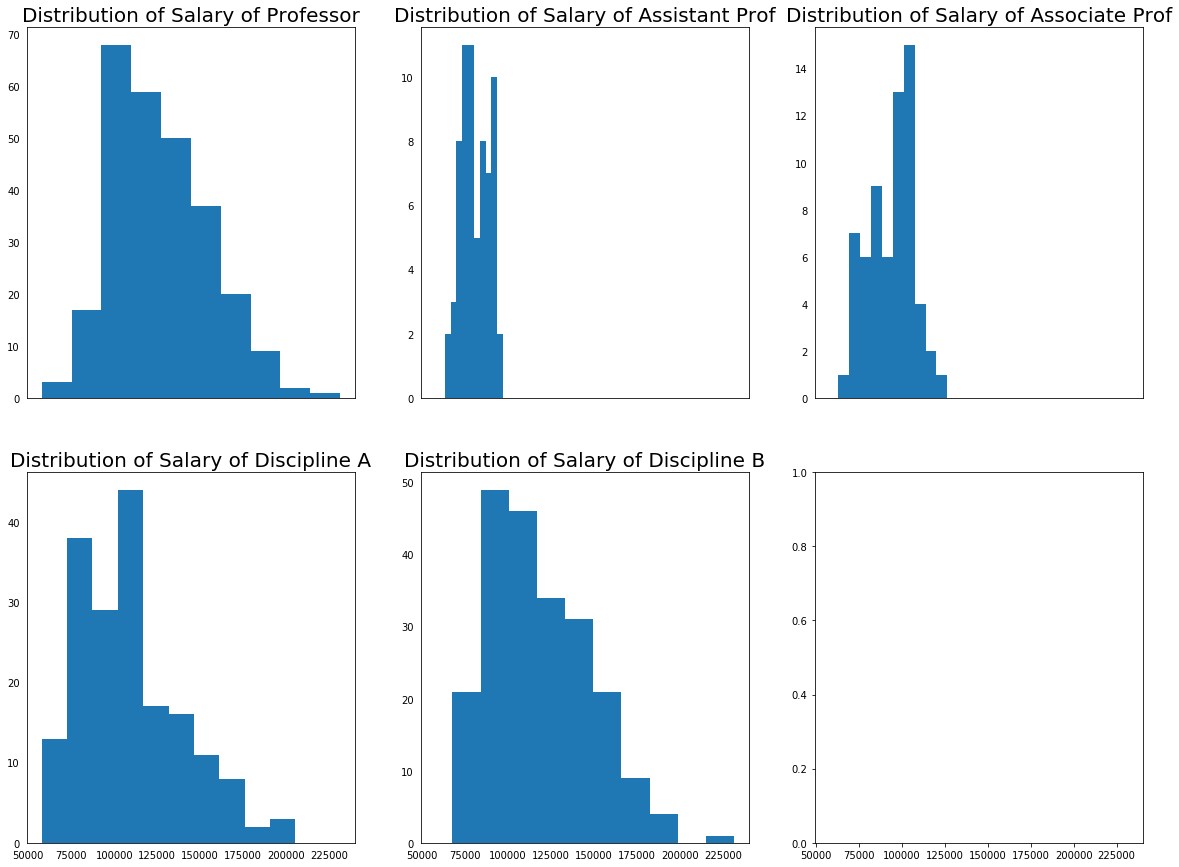

In [7]:
fig,((ax1,ax2,ax5),(ax3,ax4,ax6))=plt.subplots(2,3,sharex=True,figsize=(20,15))

for item in [ax1,ax2,ax3,ax4,ax5]:
    item.tick_params(which='both',top='off',bottom='off',left='off',right='off')
    
ax1.hist(data[data['rank']=='Prof']['salary'])
ax2.hist(data[data['rank']=='AsstProf']['salary'])
ax3.hist(data[data['discipline']=='A']['salary'])
ax4.hist(data[data['discipline']=='B']['salary'])
ax5.hist(data[data['rank']=='AssocProf']['salary'])


ax1.set_title("Distribution of Salary of Professor",fontsize=20)
ax2.set_title("Distribution of Salary of Assistant Prof",fontsize=20)
ax3.set_title("Distribution of Salary of Discipline A",fontsize=20)
ax4.set_title("Distribution of Salary of Discipline B",fontsize=20)
ax5.set_title("Distribution of Salary of Associate Prof",fontsize=20)

(4) How would you recode discipline as a 0/1 binary indicator?

LabelEncoder in sklearn can transform categorical data into 0/1 classes.

In [8]:
le = preprocessing.LabelEncoder()
#data['discipline']=le.fit_transform(data['discipline'])
#data.head()

# Part 2:

# Preprocessing Data

1. Check the correlation between variables
2. Create dummy variables for categorical data
3. Check the distribution of numeric variables
4. Since the distribution of salary is right skewed, let's use log(salary+1) to normalize it. (resulted 0.08 inprovement in R2)

In [9]:
df_with_dummies= pd.get_dummies(data,  columns=['rank','discipline','sex'])

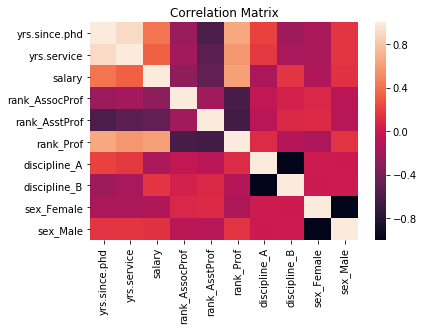

In [10]:
corr = df_with_dummies.corr()
ax = plt.axes()

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
ax.set_title('Correlation Matrix')
plt.show()

Now let's see the distribution of numeric variables and how salary relates to them.

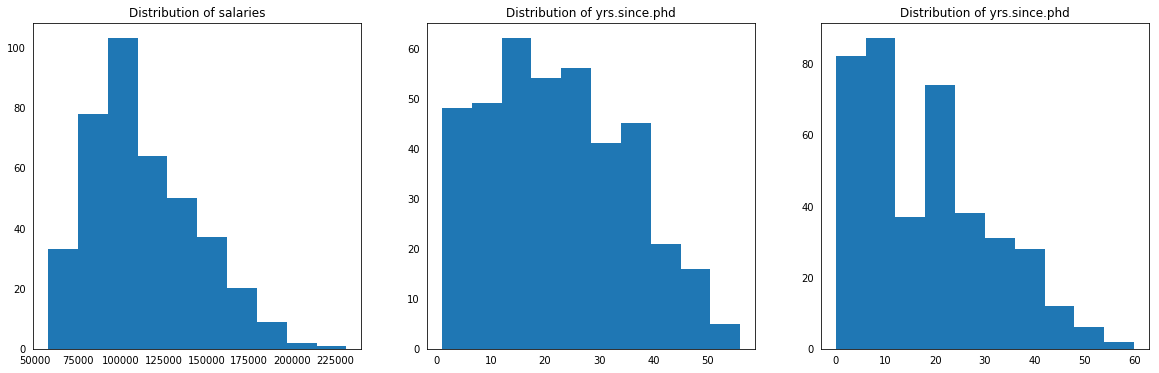

In [11]:
fig,(ax1,ax2, ax3)=plt.subplots(1,3,sharex=False,figsize=(20,6))

for item in [ax1,ax2,ax3]:
    item.tick_params(which='both',top='off',bottom='off',left='off',right='off')
    
ax1.hist(data['salary'])
ax2.hist(data['yrs.since.phd'])
ax3.hist(data['yrs.service'])

ax1.set_title("Distribution of salaries")
ax2.set_title("Distribution of yrs.since.phd")
ax3.set_title("Distribution of yrs.since.phd")

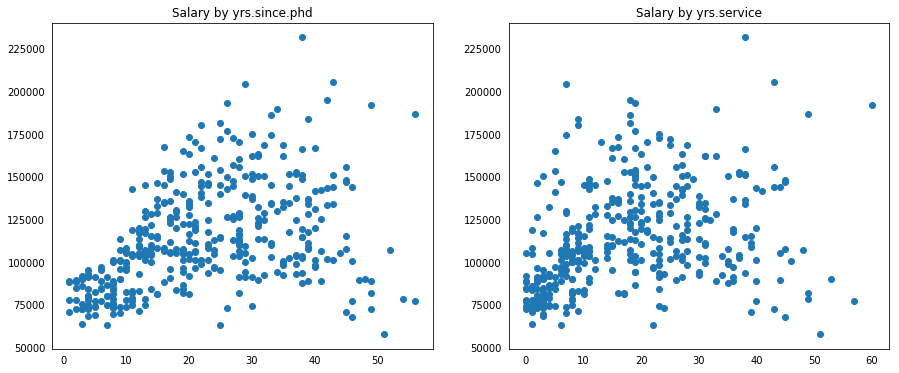

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,sharex=False,figsize=(15,6))

for item in [ax1,ax2]:
    item.tick_params(which='both',top='off',bottom='off',left='off',right='off')
    
ax1.scatter(data['yrs.since.phd'],data['salary'])
ax2.scatter(data['yrs.service'],data['salary'])

ax1.set_title("Salary by yrs.since.phd")
ax2.set_title("Salary by yrs.service")

yrs.since.phd and yes.service correlate with salary more than other variables, but still there is not a strong linear relationship between them. Also, there is a trend that as the yrs.since.phd and yrs.service increase the variance of salary also increase.

In [13]:
variable='sex'

data_plot = [dict(
  type = 'box',
  x = data[variable],
  y = data['salary'],
  mode = 'markers',
  transforms = [dict(
    type = 'groupby',
    groups = data[variable],

  )]
)]

layout={
        'xaxis': {'title': variable + ' Categories'},
        'yaxis': {'title': "Salary"},
        "title":"Distribution of Salary by " +variable
    }

off.iplot({'data': data_plot, 'layout':layout}, validate=False)

In [14]:
variable='discipline'

data_plot = [dict(
  type = 'box',
  x = data[variable],
  y = data['salary'],
  mode = 'markers',
  transforms = [dict(
    type = 'groupby',
    groups = data[variable],

  )]
)]

layout={
        'xaxis': {'title': variable + ' Categories'},
        'yaxis': {'title': "Salary"},
        "title":"Distribution of Salary by " +variable
    }

off.iplot({'data': data_plot, 'layout':layout}, validate=False)

In [15]:
variable='rank'

data_plot = [dict(
  type = 'box',
  x = data[variable],
  y = data['salary'],
  mode = 'markers',
  transforms = [dict(
    type = 'groupby',
    groups = data[variable],

  )]
)]

layout={
        'xaxis': {'title': variable + ' Categories'},
        'yaxis': {'title': "Salary"},
        "title":"Distribution of Salary by " +variable
    }

off.iplot({'data': data_plot, 'layout':layout}, validate=False)

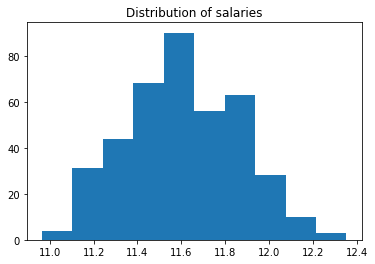

In [16]:
data['salary'] = np.log1p(data['salary'])
plt.hist(data['salary'])
plt.title("Distribution of salaries")

# Regression Model

Linear regression model + Polynomial Features + L2 Regularization

Using R2 as measurement

In [17]:
df_with_dummies= pd.get_dummies(data,  columns=['rank','discipline','sex'])
Y=df_with_dummies['salary']
X=df_with_dummies.drop('salary',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=6)

In [18]:
#this function retures the cross validation R2 and test R2
def R2(model,X_train,X_test):
    print("Train R2") 
    r2= cross_val_score(model, X_train, y_train, scoring="r2", cv = 3)
    print(r2.mean())
    y_pred=model.predict(X_test)
    print("Test R2")
    print(r2_score(y_test, y_pred))
    

In [19]:
model=LinearRegression()
model.fit(X_train,y_train)
R2(model,X_train,X_test)


Train R2
0.482799308824
Test R2
0.480537073646


In [20]:
list1, list2 = zip(*sorted(zip(model.coef_, X.columns)))
data_plot = [go.Bar(
            x=list1,
            y=list2,
            orientation = 'h',
            marker=dict(
        color='rgb(67, 67, 67)'))]
layout={
        "title":'Feature Coefficients'
    }
off.iplot({'data':data_plot,'layout':layout})

In [21]:

poly = PolynomialFeatures(2)
Y=df_with_dummies['salary']
X=df_with_dummies.drop('salary',axis=1)
X_poly=poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, Y, test_size=0.4, random_state=6)

model.fit(X_train, y_train)
R2(model,X_train,X_test)



Train R2
0.491574732883
Test R2
0.477469418892


In [22]:
clf = Ridge(alpha=20).fit(X_train, y_train)
R2(clf,X_train,X_test)

Train R2
0.515617749752
Test R2
0.484702108327


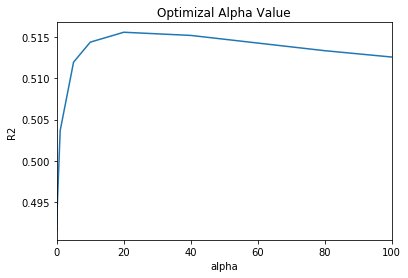

In [23]:
alphas=[0.001,0.01,0.1,1,5,10,20,40,80,100]
cv_ridge=[cross_val_score(Ridge(alpha=w), X_train, y_train, scoring="r2", cv = 3).mean() for w in alphas ]
cv_ridge=pd.Series(cv_ridge,index=alphas)
cv_ridge.plot(title="Optimizal Alpha Value")
plt.xlabel("alpha")
plt.ylabel("R2")

# Residual Plots

In [24]:
y_pred=clf.predict(X_train)
res=y_train-y_pred
Y=df_with_dummies['salary']
X=df_with_dummies.drop('salary',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=6)

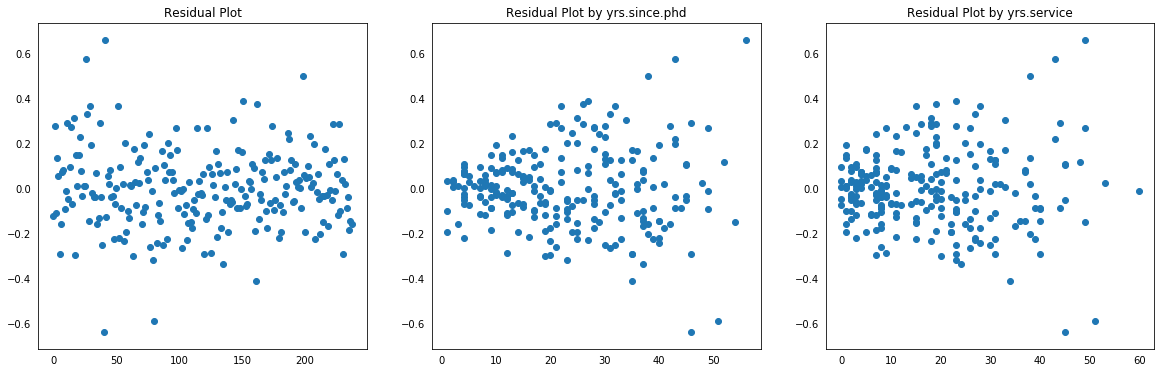

In [25]:
fig,(ax1,ax2, ax3)=plt.subplots(1,3,sharex=False,figsize=(20,6))

for item in [ax1,ax2,ax3]:
    item.tick_params(which='both',top='off',bottom='off',left='off',right='off')
    
ax1.scatter(range(len(X_train)),res)
ax1.set_title("Residual Plot")
ax2.scatter(X_train['yrs.since.phd'],res)
ax2.set_title("Residual Plot by yrs.since.phd")
ax3.scatter(X_train['yrs.service'],res)
ax3.set_title("Residual Plot by yrs.service")

The residual plot looks good. But the variance of the residual increased when the yrs.since.phd and yrs.service increase. 

# Classification Model

Use 0 to replace salaries below the median and 1 otherwise.

In [26]:
Y=df_with_dummies['salary']
X=df_with_dummies.drop('salary',axis=1)

In [27]:
Med=Y.median()
Y.loc[Y<Med]=0
Y.loc[Y>=Med]=1
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=6)

C:\Users\baoji\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [28]:
def performance(model):
    print("Mean CV Accuracy")
    print(cross_val_score(model, X_train, y_train,scoring="accuracy", cv=3).mean())
    print("Test Accuracy")
    model.fit(X_train, y_train)
    print(accuracy_score(y_test, model.predict(X_test)))
    print("Confusion Matrix")
    print(confusion_matrix(y_test, model.predict(X_test)))
    

In [29]:
clf5=LogisticRegression()
performance(clf5)

Mean CV Accuracy
0.79003164557
Test Accuracy
0.798742138365
Confusion Matrix
[[50 30]
 [ 2 77]]


In [30]:
list1, list2 = zip(*sorted(zip(clf5.coef_[0], X.columns)))
data_plot = [go.Bar(
            x=list1,
            y=list2,
            orientation = 'h',
            marker=dict(
        color='rgb(67, 67, 67)'))]
layout={
        "title":'Feature Coefficients'
    }
off.iplot({'data':data_plot,'layout':layout})

In [31]:
parameters = {'penalty':['l1','l2'], 'C':[0.001,0.01,0.1,1,5,10,20,40]}
clf_grid = GridSearchCV(clf5, parameters)
clf_grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 5, 10, 20, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [32]:
clf5=LogisticRegression(C=1,penalty='l2')
performance(clf5)

Mean CV Accuracy
0.79003164557
Test Accuracy
0.798742138365
Confusion Matrix
[[50 30]
 [ 2 77]]


GridSearch cannot improve the model.

In [33]:
y_pred_proba = clf5.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

data_plot = [go.Scatter(
    x = fpr,
    y = tpr,
    mode = 'lines+markers',
    name = 'lines+markers'
)]


layout={
        'xaxis': {'title': 'False Positive Rate'},
        'yaxis': {'title': "True Positive Rate"},
        "title": 'AUC value = ' + str(auc)
    }

off.iplot({'data':data_plot,'layout':layout})
